# Experimentation with stochastic ODE solver


In [40]:
!pip install sdeint

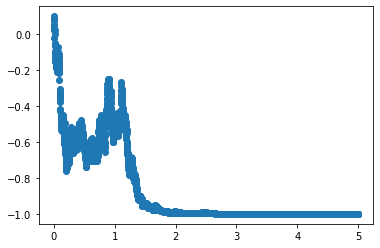

In [41]:
import numpy as np
import sdeint
import matplotlib.pyplot as plt


a = 1.0
b = 0.8
tspan = np.linspace(0.0, 5.0, 5001)
x0 = 0.1

def f(x, t):
    return -(a + x*b**2)*(1 - x**2)

def g(x, t):
    return b*(1 - x**2)

result = sdeint.itoint(f, g, x0, tspan)

plt.scatter(tspan, result)

# Model variables - legend:

complexL/U - importin-cargo complex, labeled (L) or unlabeled (U) 

freeL/U - free cargo, labeled (L) or unlabeled (U) 

c - concentration

v - volume

C - cytoplasm

N - nucleues

NPC - nuclear pore complex

nmol - number of molecules

M - molar (moles per liter)

L - liter

fL - femtoliter


# Class for simulating transport using ODEs

In [421]:
import numpy as np
import re

N_A= 6.022e+23 # Avogadro's number 

# TODO: test
def fL_to_L(v_fL):
  ''' convert femtoliters to liters '''
  return v_fL*1E-15

class TransportSimulation():

  ###########################################
  # getter/setter functions / utility
  ###########################################

  def set_nmol(self, species, value):
    self.nmol[species]= value

  def get_nmol(self, species):
    return self.nmol[species]

  def get_compartment(self, species):
    m= re.search("_([a-zA-Z]*)$", species)
    if m is None:
        raise ValueError(f"Can't parse compartment from species {species}")
    return m.group(1)

  def get_compartment_volume_L(self, species):
    compt= self.get_compartment(species)
    if compt=="N":
      return self.v_N_L
    elif compt=="C":
      return self.v_C_L
    elif compt=="cell":
      return self.v_N_L + self.v_C_L
    else:
      raise ValueError(f"Only nucleus/cytoplasm/cell has a volume (species {species} compartment {compt})") 

  def set_concentration_M(self, species, c_M):
    ''' 
    Sets the concentration of specified speciecs to c_M (in M units) 
    @raise ValueError if compartment has no volume
    '''
    global N_A
    v_L= self.get_compartment_volume_L(species)
    self.nmol[species]= c_M * v_L * N_A

  def get_concentration_M(self, species):
    ''' 
    returns the concentrations of specied species in its compartment 
    @raise ValueError if compartment has no volume
    '''
    global N_A
    v_L= self.get_compartment_volume_L(species)
    return self.nmol[species]/(N_A*v_L)

  def set_RAN_distribution(self,
                           Ran_cell_M,
                           parts_GTP_N,
                           parts_GTP_C,
                           parts_GDP_N,
                           parts_GDP_C):
    '''
    Sets the RAN distribution among compartments based on relative parts specified, s.t. total concentration is constant

    @param Ran_cell_M - total Ran concentration in cell
    @param GTP_N, GTP_C, GDP_N, GDP_C - relative quantities of all Ran species in nucleus (N) and cytoplasm (N)
    '''
    global N_A
    RAN_distribution = np.array([parts_GTP_N, parts_GTP_C,
                                 parts_GDP_N, parts_GDP_C]) 
    RAN_distribution = RAN_distribution/np.sum(RAN_distribution) # normalize to 1
    nmol_Ran_cell= Ran_cell_M * (self.v_N_L + self.v_C_L) * N_A 
    self.nmol["GTP_N"] = nmol_Ran_cell * RAN_distribution[0]
    self.nmol["GTP_C"] = nmol_Ran_cell * RAN_distribution[1]
    self.nmol["GDP_N"] = nmol_Ran_cell * RAN_distribution[2]
    self.nmol["GDP_C"] = nmol_Ran_cell * RAN_distribution[3]

  def set_v_N_L(self, v_L):
    self.v_N_L= v_L
  
  def set_v_C_L(self, v_L):
    self.v_C_L= v_L

  def get_v_N_L(self):
    return self.v_N_L
  
  def get_v_C_L(self):
    return self.v_C_L

  def get_v_cell_L(self):
    return self.v_N_L + self.v_C_L

  def set_time_step(self, dt_sec):
    ''' set time step in seconds '''
    self.dt_sec= dt_sec

  def get_time_step(self, dt_sec):
    ''' get time step in seconds '''
    self.dt_sec= dt_sec  
    
  def reset_simulation_time(self):
    self.sim_time_sec= 0.0


  ###################
  # Consturctor (and init functions)
  ###################

  def set_params(self, **kwargs):
    for param, value in kwargs.items():
        assert hasattr(self, param)
        setattr(self, param, value)

  def _init_simulation_parameters(self, **kwargs):
    # TODO: add all simulation parameters here with proper units
    self.dt_sec = 1e-4 # simulation time step  
    # NPC dock capacity:
    n_NPCs= 200 # (maximal estimate from Timney et al. 2016 paper)
    n_dock_sites_per_NPC= 500 #  dock sites for cargo-importin complexes per NPC, rule of thumb estimate  # TODO: this may depend on molecule size
    self.NPC_dock_sites = n_NPCs * n_dock_sites_per_NPC # total capacity for cargo-importin complexes in entire NPC, in number of molecules
    # Rates:  # TODO: change nmol to nmolec - to prevent confusion between moles and molecules
    self.rate_complex_to_NPC_per_free_site_per_sec_per_M = 50000.0e+6/self.NPC_dock_sites # the fraction of cargo-importin complexes that will dock to avaialble NPC dock sites per second (from either cytoplasm or nucleus)
    self.fraction_complex_NPC_to_free_N_per_M_GTP_per_sec = 0.005e+6
    self.fraction_complex_N_to_free_N_per_M_GTP_per_sec = 0.005e+6
    self.fraction_complex_NPC_to_complex_N_C_per_sec= 1.0
    self.rate_GDP_N_to_GTP_N_per_sec= 200.0
    self.rate_GTP_N_to_GDP_N_per_sec= 0.2
    self.rate_GTP_C_to_GDP_C_per_sec= 500.0
    self.rate_GTP_N_to_GTP_C_per_sec = 0.15
    self.rate_GDP_C_to_GDP_N_per_sec = 0.2
    self.rate_GDP_N_to_GDP_C_per_sec = 0.2
    self.rate_complex_C_to_free_C_per_sec = 0.05       
    self.rate_free_to_complex_per_sec = 0.10 # assuming importins are not rate limiting in either cytoplasm aor nucleus and have identical concentration
    self.passive_competition_weight= 0.0 # a number between 0.0 and 1.0 quantifying the weight of competition # TODO: this could be a flag
    self.max_passive_diffusion_rate_nmol_per_sec_per_M= 20000 # as the name suggests, without accounting for competition effects # TODO: in future, a single number for both import and export that is independent of C/N volumes, # of NPCs etc
    self.bleach_volume_L_per_sec= 1.0e-15 # cytoplasmic cargo volume being bleached per second
    self.bleach_start_time_sec= np.inf # no bleaching by default
    self.set_params(**kwargs)


  def __init__(self, **kwargs):
    ''' Set initial state of the simulation '''
    self._init_simulation_parameters(**kwargs)
    self.sim_time_sec= 0.0
    self.nmol= {} # number of molecules of various species
    # Cell geometry:
    self.v_C_L= 10e-15 # Cytoplsmic volume in L
    self.v_N_L= 3e-15 # Nuclear volume in L
     # NPC:
    self.nmol["complexL_NPC"]= 1e0 # number of cargo-importin complexes docked to the NPC (labeled)
    self.nmol["complexU_NPC"]= 0 # (unlabeled)
    # Cytoplasm:
    self.set_concentration_M("cargo_C", 50e-6)  # Nuclear concentration of labeled cargo in M
    self.nmol["complexL_C"]=  self.get_nmol("cargo_C")*0.25 # number of cargo-importin complexes in cytoplasm (labeled)
    self.nmol["freeL_C"]= self.nmol["cargo_C"] - self.nmol["complexL_C"] # number of free cargo molecules in cytoplasm (labeled)
    self.nmol["complexU_C"]= 0 # (unlabeled)
    self.nmol["freeU_C"]= 0 # (unlabeled)
    del self.nmol["cargo_C"]
    # Nucleus:
    self.set_concentration_M("cargo_N", 0e-5)  # Nuclear concentration of labeled cargo in M
    self.nmol["complexL_N"] = 0 # number of cargo-importin complexes in nucleus (labeled)
    self.nmol["freeL_N"]= self.nmol["cargo_N"] - self.nmol["complexL_N"] # number of free cargo molecules in nucleus (labeled)
    self.nmol["complexU_N"]= 0 # (unlabeled)
    self.nmol["freeU_N"]= 0 # (unlabeled)
    del self.nmol["cargo_N"] 
    # Ran in all:
    self.set_RAN_distribution(Ran_cell_M= 2e-5, # total physiological concentration of Ran # TODO: check in the literature 
                              parts_GTP_N=1000,
                              parts_GTP_C=1,
                              parts_GDP_N=1,
                              parts_GDP_C=1000)
 
  ##########################
  # Transitions calculators:
  ########################

  def get_nmol_complex_NPC_to_free_N(self):
      """
      Number of labeled cargo molecules released from the NPC to the nucleus over a self.dt_sec time step
      (Note: it is assumed each undocking leads to export of a single RanGTP molecule)

      Return: dictionary with number of molecules to add/subtract from each species
      """
      #return float(int(np.power(nmol_GTP_N/max_RAN, 5)*nmol_NPC))
      f= self.fraction_complex_NPC_to_free_N_per_M_GTP_per_sec  \
        * self.get_concentration_M("GTP_N") \
        * self.dt_sec
      nL= f * self.nmol["complexL_NPC"] 
      nU= f * self.nmol["complexU_NPC"] 
      n= nL+nU
      assert n <= self.nmol["GTP_N"] and nL <= self.nmol["complexL_NPC"] and nU <= self.nmol["complexU_NPC"]            
      return {"complexL_NPC": -nL,
              "freeL_N": +nL,
              "complexU_NPC": -nU,
              "freeU_N": +nU,
              "GTP_N": -n,
              "GTP_C": +n}
 

  def get_nmol_complex_N_to_free_N(self):
      """
      Number of labeled cargo molecules that disassemble in the nucleus over a self.dt_sec time step
      Note: it is assumed each undocking leads to export of a single RanGTP molecule instantaneously

      Return: dictionary with number of molecules to add/subtract from each species
      """
      #return float(int(np.power(nmol_GTP_N/max_RAN, 5)*nmol_NPC))
      c_GTP_N_M= self.get_concentration_M("GTP_N")
      f= self.fraction_complex_N_to_free_N_per_M_GTP_per_sec \
                        * self.get_concentration_M("GTP_N") \
                        * self.dt_sec
      nL= f * self.nmol["complexL_N"] 
      nU= f * self.nmol["complexU_N"] 
      n= nL+nU                      
 #     print("n {} GTP_N {} complex_N {}".format(n, self.nmol["GTP_N"], self.nmol["complex_N"]))
      assert n <= self.nmol["GTP_N"] and nL <= self.nmol["complexL_N"] and nU <= self.nmol["complexU_N"]            
      return {"complexL_N": -nL,
              "freeL_N": +nL,
              "complexU_N": -nU,
              "freeU_N": +nU,
              "GTP_N": -n,
              "GTP_C": +n}
 

  def get_nmol_GDP_N_to_GTP_N(self):
      """
      Number of GDP molecules in the nucleus converted to GTP

      Return: dictionary with number of molecules to add/subtract from each species
      """
      n1= self.rate_GDP_N_to_GTP_N_per_sec \
        * self.nmol["GDP_N"] \
        * self.dt_sec
      n2= self.rate_GTP_N_to_GDP_N_per_sec \
        * self.nmol["GTP_N"] \
        * self.dt_sec
      n= n1-n2
      return {"GDP_N": -n, 
              "GTP_N": +n}

  def get_nmol_GTP_C_to_GDP_C(self):
      """
      Number of GTP molecules in the cytoplasm converted to GDP

      Return: dictionary with number of molecules to add/subtract from each species
      """
      n= self.rate_GTP_C_to_GDP_C_per_sec \
        * self.nmol["GTP_C"] \
        * self.dt_sec
      return {"GTP_C": -n, 
              "GDP_C": +n}

  def get_nmol_GTP_N_to_GTP_C(self):
      """
      Number of GTP molecules exported from the nucleus

      Return: dictionary with number of molecules to add/subtract from each species
      """

      n= self.rate_GTP_N_to_GTP_C_per_sec \
        * self.nmol["GTP_N"] \
        * self.dt_sec
      return {"GTP_N": -n,
              "GTP_C": +n}

  def get_nmol_GDP_C_to_GDP_N(self):
      """
      Number of GDP molecules imported to the nucleus

      Return: dictionary with number of molecules to add/subtract from each species
      """
      n1= self.rate_GDP_C_to_GDP_N_per_sec \
        * self.nmol["GDP_C"] \
        * self.dt_sec
      n2= self.rate_GDP_N_to_GDP_C_per_sec \
        * self.nmol["GDP_N"] \
        * self.dt_sec
      n= n1-n2
      return {"GDP_C": -n,
              "GDP_N": +n}

  def get_nmol_complex_C_to_free_C(self):
      """
      The number of cargo-importin complexes that unbind importin over time step dt_sec

      Return: dictionary with number of molecules to add/subtract from each species
      """
      f= self.rate_complex_C_to_free_C_per_sec \
        * self.dt_sec
      nL= f * self.nmol["complexL_C"]
      nU= f * self.nmol["complexU_C"]
      assert(nL <= self.nmol["complexL_C"])
      assert(nU <= self.nmol["complexU_C"])
      return  {"complexL_C": -nL,
               "freeL_C": +nL,               
               "complexU_C": -nU,
               "freeU_C": +nU}

  def get_nmol_free_C_to_complex_C(self): # assume importin is not rate limiting
      """
      The number of the labeled molecules that bind to importin over time step dt_sec
      in the cytoplasm

      Return: dictionary with number of molecules to add/subtract from each species
      """
      f= self.rate_free_to_complex_per_sec \
        * self.dt_sec
      nL= f * self.nmol["freeL_C"]
      nU= f * self.nmol["freeU_C"]
      assert(nL <= self.nmol["freeL_C"])
      assert(nU <= self.nmol["freeU_C"])
      return  {"freeL_C": -nL,
               "complexL_C": +nL,               
               "freeU_C": -nU,
               "complexU_C": +nU}

  def get_nmol_free_N_to_complex_N(self): # assume importin is not rate limiting
      """
      The number of the labeled molecules that bind to importin over time step dt_sec
      in the nucleus

      Return: dictionary with number of molecules to add/subtract from each species
      """
      f= self.rate_free_to_complex_per_sec \
        * self.dt_sec
      nL= f * self.nmol["freeL_N"]
      nU= f * self.nmol["freeU_N"]
      assert(nL <= self.nmol["freeL_N"])
      assert(nU <= self.nmol["freeU_N"])
      return  {"freeL_N": -nL,
               "complexL_N": +nL,               
               "freeU_N": -nU,
               "complexU_N": +nU}


  def get_free_N_to_free_C(self): # passive
      """
      Computes the net number of unbound molecules in the nucleus that passively export 
      to the cytoplasm per second (net = export - import)

      Return: dictionary with number of molecules to add/subtract from each species

      # COMMENT: a proper treatment of this would depend on ratio between nuclear 
      # and cytoplasmic volumes, number of NPCs etc - here we ignore this for now
      # - we can change it in future based on theoretical equations of passive diffusion
      """
      # Comment: competition is assumed to have zero effect at this time
      fraction_bound_dock_sites_NPC= (self.nmol["complexL_NPC"] + self.nmol["complexU_NPC"]) / self.NPC_dock_sites
      competition_multiplier= 1.0 - self.passive_competition_weight * fraction_bound_dock_sites_NPC
      f= self.max_passive_diffusion_rate_nmol_per_sec_per_M \
        * competition_multiplier \
        * self.dt_sec
      nL= f * self.get_concentration_M("freeL_N")  - f * self.get_concentration_M("freeL_C")
      nU= f * self.get_concentration_M("freeU_N")  - f * self.get_concentration_M("freeU_C")      
      return {"freeL_N": -nL,
              "freeL_C": +nL,
              "freeU_N": -nU,
              "freeU_C": +nU}

  def get_nmol_complex_N_C_to_complex_NPC(self):
    """
    Computes the number of molecules that bind to the NPC from the nucleus
    over dt_sec time step (These will all be bound to importin)
    
    Return: dictionary with number of molecules to add/subtract from each species
    """
    nmol_free_sites_NPC = (self.NPC_dock_sites - self.nmol["complexL_NPC"] - self.nmol["complexU_NPC"])
    f = nmol_free_sites_NPC \
        * self.rate_complex_to_NPC_per_free_site_per_sec_per_M \
        * self.dt_sec
    # TODO: debug - something is weird here (BR Dec 11,2020)
    cL_N_M= self.get_concentration_M("complexL_N")
    cL_C_M= self.get_concentration_M("complexL_C")
    cU_N_M= self.get_concentration_M("complexU_N")
    cU_C_M= self.get_concentration_M("complexU_C")
    nL_N= f * cL_N_M
    nL_C= f * cL_C_M 
    nU_N= f * cU_N_M 
    nU_C= f * cU_C_M
    assert_coeff= 2.0
    assert1_almost= (nL_N+nL_C+nU_N+nU_C <= assert_coeff*nmol_free_sites_NPC) 
    assert2_almost= (nL_N+nU_N <= assert_coeff*(self.nmol["complexL_N"]+self.nmol["complexU_N"])) 
    assert3_almost= (nL_C+nU_C <= assert_coeff*(self.nmol["complexL_C"]+self.nmol["complexU_C"]))
    if(not (assert1_almost and assert2_almost and assert3_almost)):       
      assert1= (nL_N+nL_C+nU_N+nU_C <= nmol_free_sites_NPC) 
      assert2= (nL_N+nU_N <= self.nmol["complexL_N"]+self.nmol["complexU_N"]) 
      assert3= (nL_C+nU_C <= self.nmol["complexL_C"]+self.nmol["complexU_C"])
      print(self.nmol)
      print(f"f {f} dLabeled: N {nL_N} C {nL_C}, dUnlabeled: N {nU_N} C {nU_C}")
      assert(assert1)
      assert(assert2)
      assert(assert3)
      assert(assert1 and assert2 and assert3)
    return {"complexL_N": -nL_N,
            "complexL_C": -nL_C,
            "complexL_NPC": +nL_N+nL_C,
            "complexU_N": -nU_N,
            "complexU_C": -nU_C,
            "complexU_NPC": +nU_N+nU_C}

  def get_nmol_complex_NPC_to_complex_N_C(self):
      """
      Number of complexed cargo-importin released from the NPC to the nucleus and cytoplasm 
      (assumed 50-50 between nucleus and cytoplasm)

      Return: dictionary with number of molecules to add/subtract from each species
      """
      f= self.fraction_complex_NPC_to_complex_N_C_per_sec \
        * self.dt_sec # fractions are fine (conceptually, a random variable)
      nL= f * self.nmol["complexL_NPC"] 
      nU= f * self.nmol["complexU_NPC"] 
      return {"complexL_NPC": -nL,
              "complexL_N": +0.5*nL,
              "complexL_C": +0.5*nL,
              "complexU_NPC": -nU,
              "complexU_N": +0.5*nU,
              "complexU_C": +0.5*nU}

  def get_nmol_cargo_bleached(self):
    '''
    Number of bleached molecules over time step in cytoplasm (both free and complexed)

    Return: dictionary with number of molecules to add/subtract from each species
    '''
    global N_A
    if self.sim_time_sec <= self.bleach_start_time_sec:
      return {}
    f= self.bleach_volume_L_per_sec \
      * N_A \
      * self.dt_sec
    c_freeL_C_M= self.get_concentration_M('freeL_C')
    n_free_C= f * c_freeL_C_M 
    c_complexL_C_M= self.get_concentration_M('complexL_C')
    n_complex_C= f * c_complexL_C_M 
    #print(f"Bleaching {n_free_C} free cargo molecules")
    #print(self.nmol["freeL_C"], f)
    assert(n_free_C <= self.nmol["freeL_C"])
    assert(n_complex_C <= self.nmol["complexL_C"])
    return { "freeL_C": -n_free_C,
            "complexL_C": -n_complex_C,
             "freeU_C": +n_free_C,
            "complexU_C": +n_complex_C}

  ##########################
  # Individual update rules:
  ########################

  def get_nmol_T_summary(self, T_list):
      '''
      Summarize all transition by summing over a list of dictionaries of transitions

      @param T_list a list of dictionaries, each mapping from a molecular species to the change in its counts
      @return a dictionary mapping from molecular species to total change in counts
      '''
      T= {}
      for cur_T in T_list:
        for key, value in cur_T.items():
          if key in T:
            T[key] += value
          else:
            T[key] = value
      return T

  def do_one_time_step(self):
      '''
      Update all state variables for the nucleus over a single time step
      '''
      nmol_prev = self.get_total_cargo_nmol()
      # Compute transitions:
      T_list= [ 
        self.get_nmol_complex_NPC_to_free_N(),  
        self.get_nmol_complex_N_to_free_N(),
        self.get_nmol_GDP_N_to_GTP_N(),
        self.get_nmol_GTP_C_to_GDP_C(),
        self.get_nmol_GTP_N_to_GTP_C(),
        self.get_nmol_GDP_C_to_GDP_N(),
        self.get_nmol_complex_C_to_free_C(),
        self.get_nmol_free_C_to_complex_C(),
        self.get_nmol_free_N_to_complex_N(),
        self.get_free_N_to_free_C(),
        self.get_nmol_complex_N_C_to_complex_NPC(),
        self.get_nmol_complex_NPC_to_complex_N_C(),
        self.get_nmol_cargo_bleached() # TODO: bleaching still requires modeling of "dark" matter to properly model competition for binding sites on NPC, etc.
      ]
      T= self.get_nmol_T_summary(T_list)
#      print("complexL/freeL nmol cytoplasm: {:.1f} {:.1f}".format(self.nmol["complexL_C"], self.nmol["freeL_C"])) 
#      print(T)
      # Update transitions:
      for key, value in T.items():
        if (key not in self.nmol):
          raise ValueError(f"can't update non-existent molecular species {key}")
        self.nmol[key] += value 
        if(self.nmol[key] < 0):
            if self.nmol[key]>-0.001:
              T[key]= 0.0 
            else:
              print(f"Negative key {key} value {self.nmol[key]} change {value}")
              print(T)
              print(self.nmol)
              assert(self.nmol[key] >= 0)        
      # Update simulation clock:
      self.sim_time_sec += self.dt_sec

  def simulate(self, sim_time_sec, nskip_statistics= 10):
    ''' 
    simulate for approximately (and at least) sim_time_sec seconds
    @return actual time simulated
    '''
    # Computes number of steps and frames
    nsteps= int(np.ceil(sim_time_sec/self.dt_sec))
    nframes= (nsteps-1)//10 + 1
    # Prepare statistics dictionary for all molecule types
    stats= { 'time_sec' : np.zeros(nframes) }
    for key in self.nmol.keys():
      stats[key]= np.zeros(nframes)
    for i in range(nsteps):
      self.do_one_time_step()
      if i % nskip_statistics == 0:
        si= i//nskip_statistics
        stats['time_sec'][si]= self.sim_time_sec
        for key, value in self.nmol.items():
          stats[key][si]= value
    return stats

   ##########################
  # Debug utility functions
  ########################
  def get_total_RAN(self):
      RAN = self.nmol["GDP_C"] + self.nmol["GTP_C"] + self.nmol["GDP_N"] + self.nmol["GTP_N"]
      return RAN
  def get_total_cargoL_nmol(self):
      return self.nmol["complexL_C"] + self.nmol["freeL_C"] + \
        self.nmol["complexL_N"] + self.nmol["freeL_N"] + \
        self.nmol["complexL_NPC"] 
  def get_total_cargoU_nmol(self):
      return self.nmol["complexU_C"] + self.nmol["freeU_C"] + \
        self.nmol["complexU_N"] + self.nmol["freeU_N"] + \
        self.nmol["complexU_NPC"]
  def get_total_cargo_nmol(self):
      return self.get_total_cargoL_nmol() + self.get_total_cargoU_nmol()

# A few basic sanity checks

In [422]:
def utility_test():
  global N_A
  ts= TransportSimulation()
  assert(ts.get_compartment("GTP_N")=="N")
  ts.set_concentration_M("GTP_C", 5e-3)
  assert(np.isclose(ts.get_concentration_M("GTP_C"), 5e-3))
  expected_nmol= ts.get_v_C_L() * 5e-3 * N_A
  assert(np.isclose(expected_nmol, ts.get_nmol("GTP_C")))

# TODO: Kessem - update all tests

def const_test(trans_sim, n):
    for i in range(n):
      total_RAN =  trans_sim.get_total_RAN()
      total_labeled_molecules = trans_sim.get_total_cargo_nmol()

      trans_sim.do_one_time_step()

      total_RAN_post = trans_sim.get_total_RAN() 
      total_labeled_molecules_post = trans_sim.get_total_cargo_nmol()
      if np.abs(total_RAN - total_RAN_post) > 0.1:
        print("step ",i)
        print("RAN: ", total_RAN, total_RAN_post)
      if np.abs(total_labeled_molecules - total_labeled_molecules_post) > 0.1:
        print("step ",i)
        print("nmol: ", total_labeled_molecules, total_labeled_molecules_post)

def const_test_N(trans_sim, n):
  for i in range(n):
      total_RAN =  trans_sim.get_total_RAN()
      total_labeled_molecules = trans_sim.get_total_cargo_nmol()

      trans_sim.do_one_time_step()

      total_RAN_post = trans_sim.get_total_RAN() 
      total_labeled_molecules_post = trans_sim.get_total_cargo_nmol()
      if total_RAN != total_RAN_post:
        print("step ",i)
        print("RAN: ", total_RAN, total_RAN_post)
      if total_labeled_molecules != total_labeled_molecules_post:
        print("step ",i)
        print("nmol: ", total_labeled_molecules, total_labeled_molecules_post)

def const_test_C(trans_sim, n):
  for i in range(n):
      total_RAN =  trans_sim.get_total_RAN()
      total_labeled_molecules = trans_sim.get_total_nmol()

      trans_sim.do_one_time_step()
      
      total_RAN_post = trans_sim.get_total_RAN() 
      total_labeled_molecules_post = trans_sim.get_total_cargo_nmol()
      if abs(total_RAN - total_RAN_post) >= 1:
        print("step ",i)
        print("RAN: ", total_RAN, total_RAN_post)
      if abs(total_labeled_molecules - total_labeled_molecules_post) >= 1:
        print("step ",i)
        print("nmol: ", total_labeled_molecules, total_labeled_molecules_post)
        print("diff: ", total_labeled_molecules - total_labeled_molecules_post)
        print(trans_sim.c_N_M, trans_sim.c_C_M, trans_sim.nmol_NPC)

In [423]:
utility_test()
#importin_binding_rate(fraction_C_b, nmol_GDP_C)
ts = TransportSimulation()
#ts.update_N()
const_test(ts, 1000)




# Simulation main code

In [424]:
from matplotlib import pyplot as plt

def time_series(sim_time_sec, attributes, n_skip=10, **kwargs):
  '''
  TODO
  '''
  ts= TransportSimulation(**kwargs)
  ts.bleach_start_time_sec= 100.0
  ts.dt_sec= 1e-3
  n= int(np.ceil(sim_time_sec / ts.dt_sec))
  print(f"Running for n={n} time steps")
  n_frames= int(np.floor(n/n_skip)) + 1 
  c_arr = np.zeros((len(attributes), n_frames))
  i_frame= 0
  print("Cargo before: {}".format(ts.get_total_cargo_nmol()))
  for i in range(n):
    ts.do_one_time_step()
    if (i % n_skip) == 0:
      for j, attr in enumerate(attributes):
        c_arr[j,i_frame] = ts.get_nmol(attr)
      i_frame += 1
  print("Cargo after: {}".format(ts.get_total_cargo_nmol()))
  return c_arr[:,:-1]


def plot_simulation_attributes(sim_time_sec, attributes, n_skip=10, log=True, ax=None, **kwargs):
  c = time_series(sim_time_sec, attributes, n_skip= n_skip, **kwargs)
  n_frames= c.shape[1]
  x = np.arange(n_frames) * sim_time_sec / n_frames
  for i, attr in enumerate(attributes):
    if ax is None:
      plt.plot(x, c[i], label=attr)
    else:
      ax.plot(x, c[i], label=attr)
  if ax is None:
    ax= plt.gca()
  if log:
    ax.set_yscale('log')
  ax.set_xlabel("time [sec]")
  ax.set_ylabel("nmol")
  ax.legend()
  if is_log:
    ylim= ax.get_ylim()
    ylim= (10.0, ylim[1])
    ax.set_ylim(ylim)
  return c


In [425]:
sim_time_sec= 150.0
RAN_attributes = ['GDP_N', 'GDP_C', 'GTP_N', 'GTP_C']
cargoL_attributes= ['complexL_NPC', 'freeL_N', 'freeL_C', 'complexL_C', 'complexL_N']
cargoU_attributes= ['complexU_NPC', 'freeU_N', 'freeU_C', 'complexU_C', 'complexU_N']
c_attributes = ["c_C_M", "c_C_M"]
b_attributes = ['fraction_C_b', "c_C_M", ]
npc_attributes = ['nmol_NPC']
dock_attributes = ['c_C_M', 'fraction_C_b', 'nmol_NPC', 'NPC_dock_capacity']

 

Running for n=150000 time steps
Cargo before: 301101.00000000006
Cargo after: 301101.0000000056


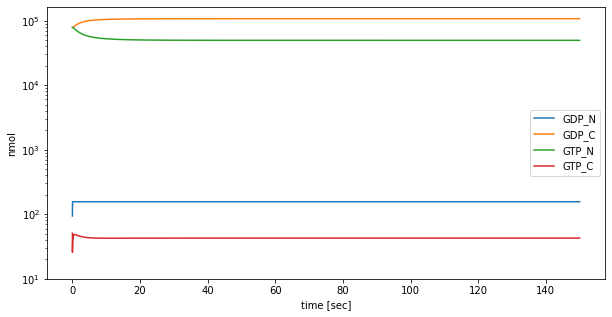

Running for n=150000 time steps
Cargo before: 301101.00000000006


In [ ]:

is_log= True
plt.figure(figsize=(10,5))
plot_simulation_attributes(sim_time_sec, RAN_attributes, log= is_log)

plt.show()
plt.figure(figsize=(10,5))
c=plot_simulation_attributes(sim_time_sec, cargoL_attributes, log= is_log)
plt.show()
plt.figure(figsize=(10,5))
c=plot_simulation_attributes(sim_time_sec, cargoU_attributes, log= is_log)
plt.show()


In [ ]:

fig, ax = plt.subplots(1, 3,figsize=(40,5))
c_1 = plot_simulation_attributes(sim_time_sec, cargoL_attributes, log= is_log, ax=ax[0], rate_GDP_N_to_GTP_N_per_sec=0.2)
c_2 = plot_simulation_attributes(sim_time_sec, cargoL_attributes, log= is_log, ax=ax[1])
ax[2].plot(c_1[-1], label='rate_GDP_N_to_GTP_N_per_sec=0.2')
ax[2].plot(c_2[-1], label='rate_GDP_N_to_GTP_N_per_sec=200.0')
ax[2].set_title("complexL_N")
ax[0].set_title("slow GDP_N to GTP_N rate")
ax[1].set_title("normal GDP_N to GTP_N rate")
ax[2].legend()

## Map parameters phasespace of transport

In [309]:

def get_tau_passive_diffusion(nmol_per_sec_per_M, volume_L):
    ''' 
    This utility function computes tau for one-sided passive diffusion
    specified in number of molecules per second per M, given
    the volume from which the passive diffusion leaves
    '''
    global N_A
    gamma= nmol_per_sec_per_M/N_A/volume_L
    tau= 1.0/gamma
    return tau



In [427]:
def get_new_transport_simulation():
    ts= TransportSimulation( )        
#    ts.set_params(rate_GDP_C_to_GDP_N_per_sec=7)   
    ts.set_params(dt_sec=1e-3)
    return ts

In [428]:
    

def map_param_grid(nx,
                   ny,
                   is_reset= False,  # whether to reset the simulation for every param combination 
                   equilibration_time_sec= 150.0, # equilibration time per condition
                   initial_equilibration_time= 300.0 # relevant only if is_reset is False 
                  ):
    param_range={}
    print(f"nx={nx} ny={ny}")
    epsilon = 1e-9
    c_cargo_M= 50e-6 # TODO: fetch this from the simulation
    param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"] = \
        np.logspace(3, #0.001+epsilon, 
                    5, #-epsilon, 
                    nx) / c_cargo_M # divided by 50E-6 to normalize by the initial cargo concentration # TODO: take the actual cargo concentration?
    param_range["rate_free_to_complex_per_sec"] = \
        np.logspace(-3, 
                    0, #-epsilon, 
                    ny)
    ts= get_new_transport_simulation()
    for key in param_range.keys():
        print("Param {:} default value is {:}".format(key, getattr(ts, key)))
    if not is_reset:
        ts.set_params(rate_free_to_complex_per_sec = param_range["rate_free_to_complex_per_sec"][0],
                  max_passive_diffusion_rate_nmol_per_sec_per_M  = param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"][0])
        ts.simulate(sim_time_sec= initial_equilibration_time, 
                    nskip_statistics= 200) #get to initial equilibrium, but don't waste time saving statistics
    stats_grids = {}
    for nmol_type in ts.nmol.keys(): # TODO: add get_nmols()
        stats_grids[nmol_type]= np.ndarray((ny, nx)) # Row major - y coordinate goes first
    for j in range(ny):
    #    print(f"j={j}")
        # scan the matrix s.t. we only do a small change each time for short equilibration times
        if (j%2==0) or is_reset:
            i_indices = range(nx)
        else:
            i_indices = range(nx-1, -1, -1)
        for i in i_indices:
            print(f"j={j} i={i}")
            if is_reset:
                ts= get_new_transport_simulation()
            ts.set_params(max_passive_diffusion_rate_nmol_per_sec_per_M  = param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"][i],
                          rate_free_to_complex_per_sec = param_range["rate_free_to_complex_per_sec"][j])        
            stats = ts.simulate(equilibration_time_sec)
            ts.reset_simulation_time()
            for nmol_type in ts.nmol.keys():
                try: 
                    stats_grids[nmol_type][j, i]= stats[nmol_type][-1] # matrix is indexed row first 
                except KeyError:
                    print(f"Key {nmol_type} not found")
    return param_range, stats_grids
        

In [429]:
def get_N_to_C_ratios(stats_grids, v_N_L, v_C_L):
    ''' return N/C ratios from stats_grids computed in the previous cell'''
    nNs= stats_grids["complexL_N"]+stats_grids["freeL_N"]+stats_grids["complexU_N"]+stats_grids["freeU_N"] 
    nCs= stats_grids["complexL_C"]+stats_grids["freeL_C"]+stats_grids["complexU_C"]+stats_grids["freeU_C"]
    ratios= (nNs/v_N_L) / (nCs/v_C_L)
    return ratios

param_range, stats_grids= map_param_grid(nx= 9,
                                        ny= 12,
                                        is_reset=True, 
                                        equilibration_time_sec= 100.0)
ratios= get_N_to_C_ratios(stats_grids, 
                          v_N_L= ts.get_v_N_L(), 
                          v_C_L= ts.get_v_C_L())

nx=9 ny=12
Param max_passive_diffusion_rate_nmol_per_sec_per_M default value is 20000
Param rate_free_to_complex_per_sec default value is 0.1
j=0 i=0
j=0 i=1
j=0 i=2
j=0 i=3
j=0 i=4
j=0 i=5
j=0 i=6
j=0 i=7
j=0 i=8
j=1 i=0
j=1 i=1
j=1 i=2
j=1 i=3
j=1 i=4
j=1 i=5
j=1 i=6
j=1 i=7
j=1 i=8
j=2 i=0
j=2 i=1
j=2 i=2
j=2 i=3
j=2 i=4
j=2 i=5
j=2 i=6
j=2 i=7
j=2 i=8
j=3 i=0
j=3 i=1
j=3 i=2
j=3 i=3
j=3 i=4
j=3 i=5
j=3 i=6
j=3 i=7
j=3 i=8
j=4 i=0
j=4 i=1
j=4 i=2
j=4 i=3
j=4 i=4
j=4 i=5
j=4 i=6
j=4 i=7
j=4 i=8
j=5 i=0
j=5 i=1
j=5 i=2
j=5 i=3
j=5 i=4
j=5 i=5
j=5 i=6
j=5 i=7
j=5 i=8
j=6 i=0
j=6 i=1
j=6 i=2
j=6 i=3
j=6 i=4
j=6 i=5
j=6 i=6
j=6 i=7
j=6 i=8
j=7 i=0
j=7 i=1
j=7 i=2
j=7 i=3
j=7 i=4
j=7 i=5
j=7 i=6
j=7 i=7
j=7 i=8
j=8 i=0
j=8 i=1
j=8 i=2
j=8 i=3
j=8 i=4
j=8 i=5
j=8 i=6
j=8 i=7
j=8 i=8
j=9 i=0
j=9 i=1
j=9 i=2
j=9 i=3
j=9 i=4
j=9 i=5
j=9 i=6
j=9 i=7
j=9 i=8
j=10 i=0
j=10 i=1
j=10 i=2
j=10 i=3
j=10 i=4
j=10 i=5
j=10 i=6
j=10 i=7
j=10 i=8
j=11 i=0
j=11 i=1
j=11 i=2
j=11 i=3
j=11 i=4
j=11 i=5
j=1

In [430]:
print(ratios)

[[ 1.25986933  1.16957379  1.09593913  1.0524917   1.02936153  1.01647369
   1.00922656  1.00515103  1.00285914]
 [ 1.45921111  1.30283811  1.17601093  1.09805073  1.05497006  1.03084306
   1.01727421  1.00964327  1.00535187]
 [ 1.84295734  1.55447855  1.32585521  1.18318454  1.10282988  1.05769993
   1.03231479  1.01803734  1.0100078 ]
 [ 2.59314605  2.03075639  1.60552256  1.34177118  1.19201715  1.10775719
   1.06034575  1.03367512  1.01867421]
 [ 4.07219639  2.92694871  2.12280749  1.63477933  1.35700673  1.20041062
   1.11222345  1.06259187  1.03466923]
 [ 6.83321528  4.53720219  3.04728431  2.16160252  1.65510003  1.36817633
   1.20616294  1.11484489  1.06342598]
 [10.24222862  6.75039982  4.42464521  2.98681615  2.13512745  1.64190873
   1.35987549  1.19976744  1.1092493 ]
 [ 8.00906903  6.31172851  4.70854315  3.40798732  2.47675668  1.86784353
   1.4929855   1.27072771  1.14187715]
 [ 4.12874122  3.77630425  3.31023553  2.77381951  2.24675002  1.80345852
   1.47685576  1.25896

[1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


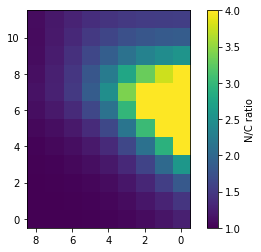

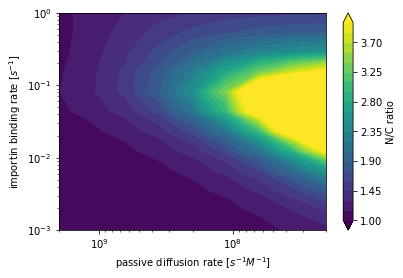

In [439]:
import matplotlib.ticker as mtick
vmax=4
x_meshgrid, y_meshgrid = np.meshgrid(param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"],
                                     param_range["rate_free_to_complex_per_sec"])
plt.figure()
ax=plt.gca()
plt.imshow(ratios, vmin=1, vmax=vmax)
xlim= ax.get_xlim()
ylim= ax.get_ylim()
ax.set_xlim(xlim[1], xlim[0])
ax.set_ylim(ylim[1], ylim[0])
cb = plt.colorbar(label="N/C ratio")
ticks = cb.get_ticks()
cb.set_ticks(ticks)
##### Contourf
plt.figure()
plt.contourf(x_meshgrid, y_meshgrid, ratios, vmin=1.0, vmax=vmax, levels=np.linspace(1.0,vmax,21), extend='both')
ax= plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r"passive diffusion rate [$s^{-1} M^{-1}$]")
ax.set_ylabel("importin binding rate [$s^{-1}$]")
xlim= ax.get_xlim()
ylim= ax.get_ylim()
ax.set_xlim(xlim[1], xlim[0])
#ax.set_ylim(ylim[1], ylim[0])
print(ax.get_xticks())
#ax.set_xticklabels(["{:.1f}".format(xtick) for xtick in param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"]])
#ax.set_yticklabels(["{:.2f}".format(ytick) for ytick in param_range["rate_free_C_to_complex_C_per_sec"]])
cb = plt.colorbar(label="N/C ratio")
ticks = cb.get_ticks()
cb.set_ticks(ticks)

#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))

#cb.set_ticklabels([f'{tick:.0e}' for tick in np.exp(ticks)])



[1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


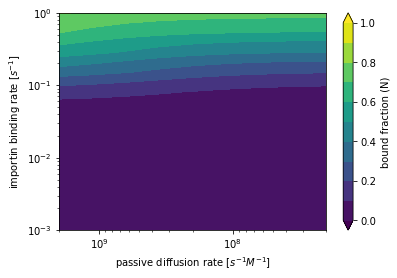

In [441]:
complexL_N_fraction= stats_grids["complexL_N"]/(stats_grids["complexL_N"]+stats_grids["freeL_N"])
complexL_C_fraction= stats_grids["complexL_C"]/(stats_grids["complexL_C"]+stats_grids["freeL_C"])


##### Contourf
vmax=1.0
plt.figure()
plt.contourf(x_meshgrid, y_meshgrid, complexL_N_fraction, 
             vmin=0.0, vmax=vmax, levels=np.linspace(0,vmax,11), extend='both')
ax= plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r"passive diffusion rate [$s^{-1} M^{-1}$]")
ax.set_ylabel("importin binding rate [$s^{-1}$]")
xlim= ax.get_xlim()
ylim= ax.get_ylim()
ax.set_xlim(xlim[1], xlim[0])
#ax.set_ylim(ylim[1], ylim[0])
print(ax.get_xticks())
#ax.set_xticklabels(["{:.1f}".format(xtick) for xtick in param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"]])
#ax.set_yticklabels(["{:.2f}".format(ytick) for ytick in param_range["rate_free_C_to_complex_C_per_sec"]])
cb = plt.colorbar(label="bound fraction (N)")
ticks = cb.get_ticks()
cb.set_ticks(ticks)

#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))

#cb.set_ticklabels([f'{tick:.0e}' for tick in np.exp(ticks)])
